# Финальный проект: вариант 2
## Задание 1. A/B–тестирование
### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

* `groups.csv` - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
* `groups_add.csv` - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
* `active_studs.csv` - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
* `checks.csv` - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### 1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

* На какие метрики Вы смотрите в ходе анализа и почему?
* Имеются ли различия в показателях и с чем они могут быть связаны?
* Являются ли эти различия статистически значимыми?
* Стоит ли запускать новую механику на всех пользователей?
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

### 1.4 Требования к ответу

* При выполнении тестового задания необходимо использовать язык программирования Python. 
* В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 

-------------------------------

Загрузим необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np

import requests
from urllib.parse import urlencode

from tqdm.auto import tqdm
from scipy.stats import norm 
import scipy.stats as ss

import seaborn as sns
import matplotlib.pyplot as plt

Загрузим датасеты:

In [2]:
# Ссылка для получения информации из области ресурсов диска
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'


# ссылки на данные + разделители для csv
links_dic = {
    'groups':       ['https://disk.yandex.ru/d/UhyYx41rTt3clQ', ';'],
    'groups_add':   ['https://disk.yandex.ru/d/5Kxrz02m3IBUwQ', ','],
    'active_studs': ['https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', ','],
    'checks':       ['https://disk.yandex.ru/d/pH1q-VqcxXjsVA', ';']
            }


# отправляем запрос на получение ссылки для скачивания и скачиваем файлы
for csv_filename, csv_link in links_dic.items():
    final_url               = base_url + urlencode(dict(public_key=csv_link[0]))
    response                = requests.get(final_url)
    download_url            = response.json()['href']
    globals()[csv_filename] = pd.read_csv(download_url, sep=csv_link[1])

-------------------------------
Сократим названия id:

In [3]:
active_studs = active_studs.rename(columns={'student_id': 'id'})
checks = checks.rename(columns={'student_id': 'id'})

Обзор данных:

In [4]:
# обзор датафреймов
# в каждом датасете проверяем уникальность всех id
for x in ['groups', 'groups_add', 'active_studs', 'checks']:
    print(x)
    y = globals()[x]
    print(y.head(), '\n')
    print('Кол-во ID:', y.id.count(), '\n')
    print('Кол-во уникальных ID:', y.id.nunique())
    print('______________________________\n\n\n')

groups
     id grp
0  1489   B
1  1627   A
2  1768   B
3  1783   B
4  1794   A 

Кол-во ID: 74484 

Кол-во уникальных ID: 74484
______________________________



groups_add
        id grp
0  5694584   B
1  5694830   B
2  5695057   B
3  5698872   B
4  5699067   B 

Кол-во ID: 92 

Кол-во уникальных ID: 92
______________________________



active_studs
        id
0   581585
1  5723133
2  3276743
3  4238589
4  4475369 

Кол-во ID: 8341 

Кол-во уникальных ID: 8341
______________________________



checks
       id    rev
0    1627  990.0
1    3185  690.0
2   25973  690.0
3   26280  690.0
4  100300  990.0 

Кол-во ID: 541 

Кол-во уникальных ID: 541
______________________________





In [5]:
for x in ['groups', 'groups_add', 'active_studs', 'checks']:
    y = globals()[x]
    print('Кол-во пропусков:', '\n', y.isna().sum(), '\n')
    print('Кол-во дупликатов:', y.duplicated().sum())
    print('______________________________\n\n\n')

Кол-во пропусков: 
 id     0
grp    0
dtype: int64 

Кол-во дупликатов: 0
______________________________



Кол-во пропусков: 
 id     0
grp    0
dtype: int64 

Кол-во дупликатов: 0
______________________________



Кол-во пропусков: 
 id    0
dtype: int64 

Кол-во дупликатов: 0
______________________________



Кол-во пропусков: 
 id     0
rev    0
dtype: int64 

Кол-во дупликатов: 0
______________________________





----------------
Требуется проверить все имеющиеся пересечения множеств id из разных таблиц.
Проверим, присутствуют ли id из `groups_add` в `active_studs` и `checks`:

In [6]:
print('Кол-во id из groups_add в active_studs:', groups_add.query('id in @active_studs.id').shape[0], 
      '\nКол-во id из groups_add в checks:',     groups_add.query('id in @checks.id').shape[0])

Кол-во id из groups_add в active_studs: 13 
Кол-во id из groups_add в checks: 1


-------------------------------
Проверим на пересечение id из `groups` и `groups_add`:

In [7]:
print('Кол-во общих id в groups и groups_add:', 
      len(set(groups_add.id) & set(groups.id)))

Кол-во общих id в groups и groups_add: 0


-------------------------------
Соединим датафрейм `groups` c датафреймом `groups_add`:

In [8]:
groups_full = pd.concat([groups, groups_add])

In [9]:
print('Доля активных пользователей, отсутствующих/присутствующих в общем списке:\n', 
      len(set(active_studs.id) - set(groups_full.id)),'/', 
      len(set(active_studs.id) & set(groups_full.id)),
      '\nДоля оплативших пользователей, отсутствующих/присутствующих в общем списке:\n',
      len(set(checks.id) - set(groups_full.id)),'/', 
      len(set(checks.id) & set(groups_full.id)),
      '\nДоля оплативших пользователей, отсутствующих/присутствующих в списке активных:\n',
      len(set(checks.id) - set(active_studs.id)),'/', 
      len(set(checks.id) & set(active_studs.id)))

Доля активных пользователей, отсутствующих/присутствующих в общем списке:
 0 / 8341 
Доля оплативших пользователей, отсутствующих/присутствующих в общем списке:
 0 / 541 
Доля оплативших пользователей, отсутствующих/присутствующих в списке активных:
 149 / 392


-------------------------------
Диаграмма Эйлера, демонстирующая имеющиеся взаимосвязи id разных табилц:

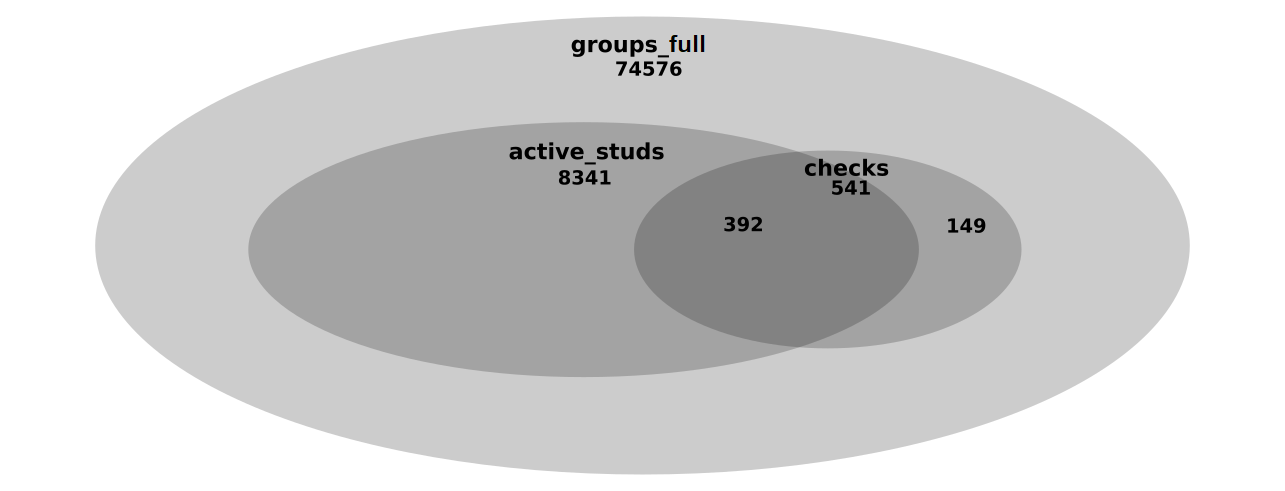

-------------
В период проведения экспериментов были оплаты и от не посещавших платформу студентов. Возможно, это оплаты другими способами, например, автоматические оплаты по подписке.

Возможно это автоматические платежи, а возможно ошибка в данных и все оплатившие являются активными. Так как у нас нет возможности выяснить это, уберём из выборки оплативших не активных.

In [10]:
checks_relev = checks[checks.id.isin(active_studs.id)]

In [11]:
checks_relev.count()

id     392
rev    392
dtype: int64

-------------------------------
Создадим таблицы с распределением активных и оплативших по группам А/B:

In [12]:
df_visit = active_studs.merge(groups_full, on='id')
df_bought = checks_relev.merge(groups_full, on='id')

Проверим в них распределение по группам:

<Axes: title={'center': 'users_bought'}, xlabel='grp', ylabel='count'>

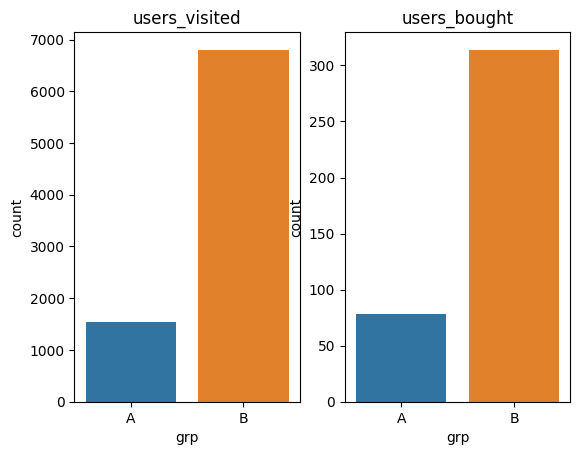

In [13]:
fig, axes = plt.subplots(1, 2)#, sharex=True, figsize=(10,5))
axes[0].set_title('users_visited')
axes[1].set_title('users_bought')
sns.countplot(ax=axes[0], x='grp', 
              data=df_visit)
sns.countplot(ax=axes[1], x='grp', 
              data=df_bought)

Проверим наличие выбросов:

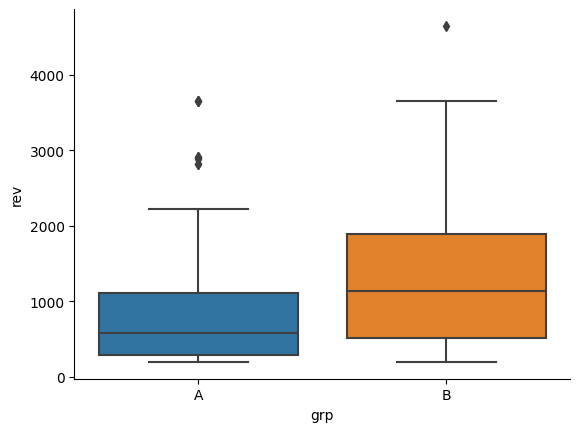

In [14]:
sns.boxplot(data=df_bought, y='rev', x='grp')
sns.despine()

Имеются незначительные выбросы.

-------------------------------
Пользователи распределены по группам неравномерно. Группа B значительно больше, чем группа А.

-------------------------------
### Выбор метрики

У нас имеются 4 переменные - 
1) id активных - df_bought.id 
2) id оплативших- df_visit.id, 
3) размер оплат - df_bought.rev
4) id всех юзеров 

<br>Как может влиять новая механика оплаты на них?
- Может увеличиться доля оплативших среди активных
- Платящие пользователи могут начать тратить больше, если оплата стала проще
- Механика не влияет на долю активных среди всех!!

<br>Данные изменения отражают 3 метрики:
- CR - конверсия из активных в оплатившие 
- ARPPU - средний доход с оплатившего юзера 
- ARPU - средний доход с активного юзера
<br>(является производной остальных двух: ARPU = CR * ARPPU)

На данные метрики также могут влиять такие факторы, как качество трафика/мотивированность пользователей, фичи конкурентов, рекламные компании и др. Дизайн эксперимента должен был исключить влияние других факторов насколько возможно.

In [15]:
CR = []
ARPPU = []
ARPU=[]

for gr in df_bought.grp.unique():
    CR.append( round( df_bought.query('grp==@gr').id.count()
              /df_visit.query('grp==@gr').id.count(), 4) )
    
    ARPPU.append( round( df_bought.query('grp==@gr').rev.mean(), 2))
    
    ARPU.append( round( df_bought.query('grp==@gr').rev.sum()/df_visit.query('grp==@gr').id.count(), 2))

percent = []
for x in [CR, ARPPU, ARPU]:
    percent.append( round( abs( 100*(x[1]-x[0])/x[0]), 2))
    
print('\n\033[1mCR\033[0m\nКонверсия оплативших пользователей:\nГруппа А:',
      CR[0], '\nГруппа В:', CR[1],
      '\nКонверсия у группы В на', percent[0],
      '% меньше, чем у группы А')

print('\n\033[1mARPPU\033[0m\nОтношение общей суммы на количество активных оплативших пользователей:\nГруппа А:',
      ARPPU[0], '\nГруппа В:', ARPPU[1],
      '\nARPPU группы В на', percent[1],
      '% больше, чем у группы А')

print('\n\033[1mARPU\033[0m\nОтношение общей суммы на количество активных пользователей:\nГруппа А:',
      ARPU[0], '\nГруппа В:', ARPU[1],  
      '\nARPU группы В на', percent[2],
      '% больше, чем у группы А')


CR
Конверсия оплативших пользователей:
Группа А: 0.0507 
Группа В: 0.0462 
Конверсия у группы В на 8.88 % меньше, чем у группы А

ARPPU
Отношение общей суммы на количество активных оплативших пользователей:
Группа А: 933.59 
Группа В: 1257.88 
ARPPU группы В на 34.74 % больше, чем у группы А

ARPU
Отношение общей суммы на количество активных пользователей:
Группа А: 47.35 
Группа В: 58.06 
ARPU группы В на 22.62 % больше, чем у группы А


-------------------------------
### Имеются ли различия в показателях и с чем они могут быть связаны?
Видим, что конверсия `CR` падает, но доход на пользователя/покупателя `ARPU`/`ARPPU` растёт. 

Возможно падение конверсии случайно, в то время как рост `ARPPU` нет, нужны результаты о статистической значимости. Кроме того, ответ в такой ситуации может крыться в сегментах/срезах. Посмотрим на распределение чеков в поисках ответов.

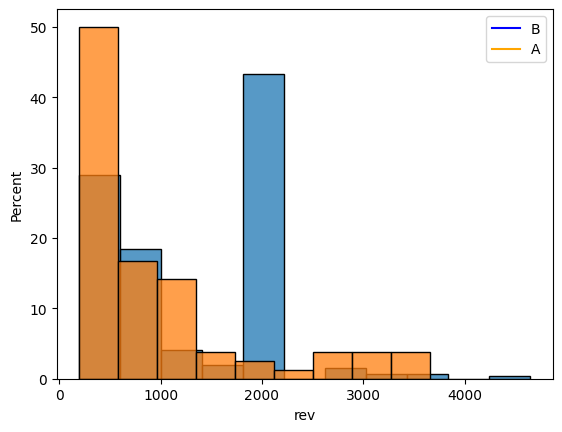

In [16]:
from matplotlib.lines import Line2D

f, ax = plt.subplots(1, 1)
a = Line2D([], [], color='blue', label='B')
b = Line2D([], [], color='orange', label='A')

sns.histplot(ax=ax, data=df_bought.query('grp=="B"').rev, stat='percent')
sns.histplot(ax=ax, data=df_bought.query('grp=="A"').rev, stat='percent')

plt.legend(handles=[a, b])
#ax.legend(labels=["B", "A"])

In [17]:
pd.concat([df_bought.query('grp=="B"').rev.describe().to_frame().rename(columns={'rev': 'Группа В'}), 
           df_bought.query('grp=="A"').rev.describe().to_frame().rename(columns={'rev': 'Группа A'})], axis=1)

,Группа В,Группа A
count,314.000000,78.000000
mean,1257.878992,933.589744
std,790.864254,919.932711
min,199.000000,199.000000
25%,511.750000,290.000000
50%,1140.000000,585.000000
75%,1900.000000,1114.750000
max,4650.000000,3660.000000


Возможно при уменьшении конверсии произошло отсечение части пользователей платящих малые суммы.

Стоит отметить, что данные распределены не нормально. 

-------------------------------
### Являются ли эти различия статистически значимыми?
При сравнении конверсии у нас имеется две номинативные переменные: 1.)оплатил/не_оплатил 2.)grp, поэтому стоит использовать `Хи-квадрат`.
<br>ARPU и ARPPU - зависимость количественной переменной(rev) от номинативной(grp).
Из гистограм видно, что распределение наших данных значительно отличается от нормального. Также известно о наличии выбросов.
Поэтому вместо Т-теста стоит использовать Mann-Whitney или Bootstrap. Результаты Mann-Whitney сложнее интерпретировать, поэтому используем `bootstrap`.

* Строим `bootstrap` распределения для групп А и B.
* Вычислим их разницу.
* В получившемся рапределении разницы находим доверительный интервал.
* Проверяем, попадает ли доверительный интервал в 0. Если да, то нулевая гипотеза на данном уровне значимости принимается, если нет - отвергается.

-------------------------------
### CR

Сформулируем нулевую и альтернативную гипотезы:

* `H0`: CR в двух группах одинаковые.
* `H1`: CR в двух группах различаются.

In [18]:
group_A = [df_visit.query('grp=="A"').count()[0], df_bought.query('grp=="A"').count()[0]]
group_B = [df_visit.query('grp=="B"').count()[0], df_bought.query('grp=="B"').count()[0]]

# Запустим тест
chi2, p, dof, ex = ss.chi2_contingency([group_A, group_B], correction=False)
print("Хи-квадрат p-value: ", p)

Хи-квадрат p-value:  0.4672642540463894


**Нельзя утверждать, что различия CR в двух группах есть.**

-----
Функция для проверки гипотез с помощью bootstrap:

In [19]:
def get_bootstrap(
    data_column_1,                       # числовые значения первой (контрольной) выборки
    data_column_2,                       # числовые значения второй (тестовой) выборки
    boot_it   = 1000,                    # количество бутстрэп-подвыборок
    statistic = np.mean,                 # интересующая нас статистика
    bootstrap_conf_level = 0.95,         # уровень значимости
    graph         = True,                # отрисовывать ли график
    show_progress = True                 # показывать ли индикатор програсса
    ):
    boot_len  = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    
    # выбираем отрисовывать индикатора програсса или нет
    if show_progress:
        progress_bar = tqdm
    else:
        progress_bar = lambda x: x
    
    for i in progress_bar(range(boot_it)):        # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True                        # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        samples_delta = samples_2 - samples_1      # находим разницу подвыборок
        boot_data.append(statistic(samples_delta)) # применяем статистику для разниц подвыборок
        
    pd_boot_data = pd.DataFrame(boot_data)

    # доверительный интервал 
    left_quant  = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x     = 0, 
        loc   = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x     = 0, 
        loc   = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # отрисовка графиков
    if graph == True:
        plt.hist(pd_boot_data[0], bins = 50)
        plt.style.use('ggplot')
        plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()
       
    return {"ci": ci, 
            "p_value": p_value}

Данная функция требует на вход два столбца данных(А и B) и функцию подсчета метрики.

<br>Для ARPPU и ARPU подойдет ф-я np.mean(x):

In [20]:
def mean_f(y):
    return np.mean(y)

Эти функции требуют создания новых датафреймов и столбцов.
_________________
Объединим таблицы клиентов и юзеров: 

In [21]:
df_visit_bought = df_visit.merge(df_bought, on=['id', 'grp'], how='left')

Заполним пропущенные значения оплат нулями:

In [22]:
df_visit_bought.rev = df_visit_bought.rev.fillna(0)

разделим на группы A и B:

In [23]:
grp_a = df_visit_bought.query('grp=="A"')
grp_b = df_visit_bought.query('grp=="B"')

-------------------------------
### ARPU
Сформулируем нулевую и альтернативную гипотезы:

* `H0`: ARPU в двух группах одинаковые.
* `H1`: ARPU в двух группах различаются.

In [24]:
get_bootstrap(grp_a.rev, grp_b.rev, statistic = mean_f, 
              graph = False, show_progress = False)

{'ci':                0
 0.025   0.362366
 0.975  21.172215,
 'p_value': 0.04454591484050235}

Доверительный интервал **не попадает в 0**, отвергаем нулевую гипотезу. ARPU в двух группах различаются.

-------------------------------
### ARPPU
Сформулируем нулевую и альтернативную гипотезы:

* `H0`: ARPPU в двух группах одинаковые.
* `H1`: ARPPU в двух группах различаются.

In [25]:
get_bootstrap(grp_a.rev[grp_a.rev > 0], grp_b.rev[grp_b.rev > 0], statistic = mean_f, 
              graph = False, show_progress = False)

{'ci':                 0
 0.025  195.703594
 0.975  463.276444,
 'p_value': 1.1842881943704748e-06}

Доверительный интервал **не попадает в 0**, отвергаем нулевую гипотезу. ARPPU в двух группах различаются.

-------------------------------
**У нас имеется неопределенность по поводу юзеров которые оплатили**, но не присутствовали на сайте.
<br>У меня нету возможности распросить коллег/заказщика о причине этой аномалии. Поэтому мне стоит на всякий случай провести все тесты, на этот раз включая эти данные

In [26]:
df_visit = active_studs.merge(groups_full, on='id')
df_bought = checks.merge(groups_full, on='id') #использую checks а не checks_relev

In [27]:
df_visit_bought = df_visit.merge(df_bought, on=['id', 'grp'], how='left')

Заполним пропущенные значения оплат нулями:

In [28]:
df_visit_bought.rev = df_visit_bought.rev.fillna(0)

разделим на группы A и B:

In [29]:
grp_a = df_visit_bought.query('grp=="A"')
grp_b = df_visit_bought.query('grp=="B"')

In [30]:
group_A = [df_visit.query('grp=="A"').count()[0], df_bought.query('grp=="A"').count()[0]]
group_B = [df_visit.query('grp=="B"').count()[0], df_bought.query('grp=="B"').count()[0]]

# Запустим тест
chi2, p, dof, ex = ss.chi2_contingency([group_A, group_B], correction=False)
print("Хи-квадрат p-value: ", p)

Хи-квадрат p-value:  0.43714838107439424


In [31]:
get_bootstrap(grp_a.rev, grp_b.rev, statistic = mean_f, 
              graph = False, show_progress = False)

{'ci':                0
 0.025   0.572343
 0.975  20.427308,
 'p_value': 0.037047285172488544}

In [32]:
get_bootstrap(grp_a.rev[grp_a.rev > 0], grp_b.rev[grp_b.rev > 0], statistic = mean_f, 
              graph = False, show_progress = False)

{'ci':                 0
 0.025  189.473260
 0.975  460.508213,
 'p_value': 1.4689904356023145e-06}

Тесты показали те же результаты.

-------------------------------
### Стоит ли запускать новую механику на всех пользователей?
**Да**, новая механика оплаты даёт статистически значимый прирост в метриках ARPU и ARPPU, отрицательное изменение метрики CR не подтвердилось.

## Задание 2. SQL
### 2.1 Очень усердные ученики.

### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

### 2.1.2 Задача

Дана таблица `default.peas`:

Название атрибута | Тип атрибута | Смысловое значение
------------------|--------------|-------------------
st_id | int | ID ученика
timest | timestamp | Время решения карточки
correct | bool | Правильно ли решена горошина?
subject | text | Дисциплина, в которой находится горошина

Необходимо написать <ins>оптимальный запрос</ins>, который даст информацию о количестве очень усердных студентов.

*NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.*

### 2.2 Оптимизация воронки

### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

2.2.2 Задача

Дана таблицы: `default.peas` (см. выше), `default.studs`:

Название атрибута | Тип атрибута |Смысловое значение
------------------|--------------|-------------------
st_id|	int |	ID ученика
test_grp	|text 	|Метка ученика в данном эксперименте

и `default.final_project_check`:


Название атрибута	|Тип атрибута 	|Смысловое значение
------------------|--------------|-------------------
st_id|	int |	ID ученика
sale_time|	timestamp	|Время покупки
money|	int	|Цена, по которой приобрели данный курс
subject|	text |	Дисциплина, на которую приобрели полный доступ

Необходимо <ins>в одном запросе</ins> выгрузить следующую информацию о группах пользователей:

* ARPU 
* ARPAU 
* CR в покупку 
* СR активного пользователя в покупку 
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

**Активным** считается пользователь, за все время решивший **больше** 10 задач правильно в любых дисциплинах.

**Активным** по математике считается пользователь, за все время решивший **2 или больше задач** правильно по математике.


In [1]:
import pandahouse as ph

In [2]:
connection2 = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [3]:
query = """
SELECT count(*)
FROM
(SELECT st_id
FROM peas
WHERE correct=1
GROUP BY st_id
HAVING count(*)>=20) as subq
"""

df = ph.read_clickhouse(query, connection=connection2)
df.head()

,count()
0,136


In [4]:
query = '''
SELECT
    test_grp,
    sum(total_revenue) / uniqExact(st_id) as ARPU,
    sumIf(total_revenue, active_stud=1) / uniqExactIf(st_id, active_stud=1) as ARPAU,
    uniqExactIf(st_id, total_revenue > 0) / uniqExact(st_id) as CR_to_buy,
    
    uniqExactIf(st_id, active_stud=1 and total_revenue>0) 
        / uniqExactIf(st_id, active_stud=1) as CR_active_to_buy,
        
    uniqExactIf(st_id, math_active_stud=1 and math_revenue>0) 
        / uniqExactIf(st_id, math_active_stud=1) as CR_math_active_to_buy_math
FROM

    (
    SELECT 
        l.test_grp as test_grp,
        l.st_id as st_id,
        r.active_stud as active_stud,
        r.math_active_stud as math_active_stud,
        r.total_revenue as total_revenue,
        r.math_revenue as math_revenue
    FROM
    
        (
        SELECT
            test_grp,
            st_id
        FROM studs
        ) as l
        
    LEFT JOIN
        (
        SELECT
            l.st_id as st_id,
            l.active_stud as active_stud,
            l.math_active_stud as math_active_stud,
            r.total_revenue as total_revenue,
            r.math_revenue as math_revenue
        FROM
            (
            SELECT
                st_id,
                if (sum(correct) > 10, 1, 0) as active_stud,
                if (sumIf(correct, subject='Math') >= 2, 1, 0) as math_active_stud
            FROM peas
            GROUP BY
                st_id
            ) as l
            
        LEFT JOIN
            (
            SELECT
                st_id,
                sum(money) as total_revenue,
                sumIf(money, subject='Math') as math_revenue
            FROM final_project_check
            GROUP BY st_id
            ) as r
        ON l.st_id = r.st_id
        
        ) as r
    ON l.st_id = r.st_id
    
    )
GROUP BY
    test_grp
'''

df2 = ph.read_clickhouse(query, connection=connection2)
df2.head()

,test_grp,ARPU,ARPAU,CR_to_buy,CR_active_to_buy,CR_math_active_to_buy_math
0,control,4540.983607,10393.700787,0.049180,0.110236,0.061224
1,pilot,11067.796610,29739.583333,0.101695,0.260417,0.095238


## Задание 3. Python
### 3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла `groups_add.csv` (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

-------------------------------

Предположим, что у нас уже получен объединенный датафрейм:

In [1]:
import pandas as pd
import numpy as np

import requests
from urllib.parse import urlencode

from tqdm.auto import tqdm
from scipy.stats import norm 
import scipy.stats as ss

import seaborn as sns
import matplotlib.pyplot as plt

import re

Установка пакета kaleido, чтобы github отобразил индиакторы прироста метрик из библиотеки plot.ly 

In [2]:
pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.


Не будем дублировать функцию бутстрапа внутри нашей функции, объявим ее заранее:

In [3]:
def get_bootstrap(
    data_column_1,                       # числовые значения первой (контрольной) выборки
    data_column_2,                       # числовые значения второй (тестовой) выборки
    boot_it   = 1000,                    # количество бутстрэп-подвыборок
    statistic = np.mean,                 # интересующая нас статистика
    bootstrap_conf_level = 0.95,         # уровень значимости
    graph         = True,                # отрисовывать ли график
    show_progress = True                 # показывать ли индикатор програсса
    ):
    boot_len  = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    
    # выбираем отрисовывать индикатора програсса или нет
    if show_progress:
        progress_bar = tqdm
    else:
        progress_bar = lambda x: x
    
    for i in progress_bar(range(boot_it)):        # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True                        # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        samples_delta = samples_2 - samples_1      # находим разницу подвыборок
        boot_data.append(statistic(samples_delta)) # применяем статистику для разниц подвыборок
        
    pd_boot_data = pd.DataFrame(boot_data)

    # доверительный интервал 
    left_quant  = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x     = 0, 
        loc   = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x     = 0, 
        loc   = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # отрисовка графиков
    if graph == True:
        plt.hist(pd_boot_data[0], bins = 50)
        plt.style.use('ggplot')
        plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()
       
    return {"ci": ci, 
            "p_value": p_value}

Допустим, что у нас имеется датафрейм:

In [4]:
links_dic = {
    'groups':       ['groups.csv', ';'],
    'active_studs': ['active_studs.csv', ','],
    'checks':       ['checks.csv', ';']
            }

for csv_filename, csv_link in links_dic.items():
    globals()[csv_filename] = pd.read_csv(csv_link[0], sep=csv_link[1])

In [5]:
active_studs = active_studs.rename(columns={'student_id': 'id'})
checks = checks.rename(columns={'student_id': 'id'}).assign(payment = 1)

In [6]:
df = pd.merge(pd.merge(active_studs, checks, on='id', how='left'), groups, on='id').assign(step=0)

In [7]:
df = df.fillna(0)

In [8]:
df.head()

,id,rev,payment,grp,step
0,581585,0.0,0.0,A,0
1,3276743,0.0,0.0,B,0
2,4238589,0.0,0.0,A,0
3,4475369,0.0,0.0,B,0
4,5481015,0.0,0.0,B,0


У нас имеется ссылка на дополнительный файл (на Яндекс.Диске, или локально):

In [9]:
# ссылка на дополнительный файл
add_csv_link = 'group_add.csv'
# или add_csv_link = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'  

**Напишем функцию, которая будет автоматически подгружать информацию из дополнительного файла `groups_add.csv` и пересчитывать метрики:**

In [10]:
def update_metrics(df, add_csv_link, last_string=False):
    '''
    Функция пересчёта метрик.
    На выходе - датафрэйм со значениями метрик и p-value, 
    Кол-во строк соответствует кол-ву повторных обновлений данных(step)
    df       - объединённый дф из groups.csv, active_studs.csv, checks.csv (получены в первый раз).
    add_csv_link  - ссылка на дополнительный файл groups_add.csv, 
                    возможно использование web-ссылки на Яндекс.Диск, или ссылки на файл в каталоге.
    last_string         - если True, выведет только последнюю (финальную) строку таблицы.
    '''
    #3 подфункции:
    # ф-я определения разделителя в csv-файле
    def def_sep(file_link):
        with open(file_link, 'r') as file:
            temp = file.readline()
        pattern = re.compile(r'\w*([,;])\w*')
        return pattern.findall(temp)[0]


    # переименовываем колонки по типу данных
    def rename_cols(df):
        if str(df.iloc[0, 0]).isalpha():
            df.columns = ['grp', 'id']
        else:
            df.columns = ['id', 'grp']

    # чистим и заполняем пропуски 
    def na_filter(df, to_dropna_ls=['grp'], to_fillna_ls=['payment', 'rev']):
        df = (df
             .copy()
             .dropna(subset=to_dropna_ls)
             )
        for i in to_fillna_ls:
            df[i] = df[i].fillna(0)
        return df
    
    # ф-я среднего, необходимая для ф-ии бутстрапа
    def mean_f(y):
        return np.mean(y)

    try:
        if add_csv_link.startswith('https://'):

            # скачиваем дополнительный файл
            base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
            final_url    = base_url + urlencode(dict(public_key=add_csv_link))
            response     = requests.get(final_url)
            download_url = response.json()['href']
            group_add_df = pd.read_csv(download_url, sep=',')

            # загружаем файл и сохраняем его
            download_response = requests.get(download_url)
            with open('group_add.csv', 'wb') as f:
                f.write(download_response.content)

            # открываем файл
            group_add_df = pd.read_csv('group_add.csv', sep=def_sep('group_add.csv'))
        else:

            # открываем файл
            group_add_df = pd.read_csv(add_csv_link, sep=def_sep(add_csv_link))
    except:
        print('ОШИБКА! Дополнительные пользователи не загружены')
        
    # переименуем колонки в соответствие с типом данных
    rename_cols(group_add_df)
    
    # объединяем основной дф с дополнительным
    df          = df.merge(group_add_df, on='id', how='outer')
    df['grp_x'] = df.grp_x.fillna('')                  # заполняем пропуски пустым символом
    df['grp_y'] = df.grp_y.fillna('')                  # заполняем пропуски пустым символом
    df['grp']   = df.grp_x + df.grp_y             # объединяем колонки групп
    df          = df.drop(['grp_x', 'grp_y'], axis=1)  # удаляем колонки grp_x и grp_y

    # присваиваем значения step в добавленных строках
    mask = df.id.isin(group_add_df.id)             # назначаем маску, согласно которой будем присваивать новый номер степа
    df.loc[mask, 'step'] = df.step.max() + 1  # присваиваем номер степа
    df['step'] = df.step.astype('int')        # переводим колонку степ в int
    
    # отфильтруем пропуски
    df = na_filter(df)
    
    # пересчитываем метрики, каждый цикл - новое добавление файла groups_add
    df_ab = pd.DataFrame()  # пустой датафрейм для заполнения 

    for i in range(df.step.max() + 1):  # итеритуемся по максимальному значению колонки step +1
        # фильтруем датасет для рассчёта метрик
        rev_a      = df.query('step <= @i and grp =="A"').rev
        rev_b      = df.query('step <= @i and grp =="B"').rev
        rev_positive_a = df.query('step <= @i and rev > 0 and grp =="A"').rev
        rev_positive_b = df.query('step <= @i and rev > 0 and grp =="B"').rev
    
        all_A   = df[df.payment==0].query('step <= @i and grp=="A"').count()[0]
        payed_A = df[df.payment==1].query('step <= @i and grp=="A"').count()[0]
        all_B   = df[df.payment==0].query('step <= @i and grp=="B"').count()[0]
        payed_B = df[df.payment==1].query('step <= @i and grp=="B"').count()[0]

        #конверсия по группам 
        cr_a = payed_A/all_A
        cr_b = payed_B/all_B
        #Хи - квадрат тест конверсии
        group_A = [all_A, payed_A]
        group_B = [all_B, payed_B]
  
        chi2, cr_p_value, dof, ex = ss.chi2_contingency([group_A, group_B], correction=False)
        
        #ARPU по группам
        arpu_a = mean_f(rev_a)
        arpu_b = mean_f(rev_b)
        #ARPU p-value
        arpu_p_value = get_bootstrap(rev_a, 
                                     rev_b,
                                     statistic=mean_f,
                                     graph = False,
                                     show_progress = False
                       )["p_value"]
        #ARPPU по группам
        arppu_a       = mean_f(rev_positive_a)
        arppu_b       = mean_f(rev_positive_b)
        #ARPPU p-value
        arppu_p_value = get_bootstrap(rev_positive_a,
                                      rev_positive_b,
                                      statistic=mean_f,
                                      graph = False,
                                      show_progress = False
                        )["p_value"]

        # временный датафрэйм
        temp_df = pd.DataFrame([[cr_a, 
                                 cr_b, 
                                 cr_p_value, 
                                 arpu_a, 
                                 arpu_b, 
                                 arpu_p_value, 
                                 arppu_a, 
                                 arppu_b, 
                                 arppu_p_value]],
                               columns=['CR_A',
                                        'CR_B',
                                        'CR_p-value',
                                        'ARPU_A',
                                        'ARPU_B',
                                        'ARPU_p-value', 
                                        'ARPPU_A',
                                        'ARPPU_B',
                                        'ARPPU_p-value'])
        # добавляем строку в итоговый дф
        df_ab = pd.concat([df_ab, temp_df])      
    
    # сбрасываем индексы
    df_ab.reset_index(drop=True, inplace=True)  
    df_ab['step'] = df_ab.index
    
    if last_string == True:
        return df_ab.tail(1)
    
    return df_ab

В функцию `get_update` передадим предварительно сформированный датафрейм `total_test`:

In [11]:
metrics = update_metrics(df, add_csv_link)
metrics

,CR_A,CR_B,CR_p-value,ARPU_A,ARPU_B,ARPU_p-value,ARPPU_A,ARPPU_B,ARPPU_p-value,step
0,0.053535,0.048302,0.428082,47.439739,57.864567,0.041592,933.589744,1255.827487,0.000008,0
1,0.052738,0.047786,0.447235,46.769428,57.274370,0.035144,933.589744,1255.827487,0.000002,1


Напишем функцию отрисовки графиков:

In [16]:
def get_graphs(df):
    '''
    Функция построения графика на основе датасэта, сформированного функцией get_update
    Шесть графиков: 
    по оси X - номер обновления (колонка step в передаваемом дф), показывает 
    какой раз обновились данные (некий аналог временной шкалы, т.к. не известны даты создания 
    дополнительных файлов)
    по оси Y - метрики (верхний ряд графиков) и p-value этих метрик (нижний ряд графиков)
    '''
    # формируем датафрэйм для отрисовки метрик
    import pandas as pd
    metrix_df = pd.DataFrame(columns = ['step', 'group'])                     # создаём пустой финальный дф для построения графиков метрик
    for i in ['CR_', 'ARPU_', 'ARPPU_']:                                      # список части названий колонок для отбора
        cols    = df.filter(like = i).columns                                 # отбираем колонки содержащие названия метрик
        temp_df = pd.DataFrame()                                              # создаём пустой дф
        for j in cols[:2]:                                                    # итерируемся по названиям колонок, кроме p-value
            tmp_row         = df[[j, 'step']] \
            .assign(group = j[-1:]) \
            .rename(columns = {j: j[:-2]})  # формируем строку нового дф
            temp_df         = pd.concat([temp_df, tmp_row])                   # добавляем строку в промежуточный дф
        metrix_df = metrix_df \
                    .merge(temp_df, on=['step', 'group'], how='right')        # объединяем промежуточный дф с финальным

    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import pandas as pd

    df1 = metrix_df.query('step==0').drop(columns=['step']).set_index("group")
    df2 = metrix_df.query('step==1').drop(columns=['step']).set_index("group")

    fig = make_subplots(
        rows=len(df1),
        cols=len(df1.columns),
        specs=[[{"type": "indicator"} for c in range(3)] for t in range(2)]
    )

    for r, grp in enumerate(df1.index):
        for c, metr in enumerate(df1.columns):
            fig.add_trace(
                go.Indicator(mode="number+delta", value=df1.loc[grp, metr], title={"text":f"{metr} - {grp}"},
                             delta = {'reference': df2.loc[grp, metr], 
                         'relative': True}),
                row=r + 1,
                col=c + 1,
            )

    fig.update_layout(margin={"l": 0, "r": 20, "t": 50, "b": 0})       
    # формируем блок из 6 графиков

    figure, axes = plt.subplots(2, 3, sharex=True, figsize=(16,7))   
       
    # заголовок
    figure.suptitle('Метрики и p-value', fontsize=20)   
    
    # графики CR и p-value для CR
    sns.lineplot(ax=axes[0, 0], data=metrix_df, x='step', y='CR', hue='group', linewidth=2, palette=['b', 'g'])
    ax1 = sns.lineplot(ax=axes[1, 0], data=df, x='step', y='CR_p-value', linewidth=2, color="green", label='p-value')
    ax1.axhline(0.05, ls='--', linewidth=1.5, color='red', label='p-value = 0.05')
    ax1.set_ylabel('P-value для CR')
    ax1.set_xlabel('Номер обновления')
    ax1.legend()
    
    # графики ARPU и p-value для ARPU
    sns.lineplot(ax=axes[0, 1], data=metrix_df, x='step', y='ARPU', hue='group', linewidth=2, palette=['b', 'g'])
    ax2 = sns.lineplot(ax=axes[1, 1], data=df, x='step', y='ARPU_p-value', linewidth=2, color="green", label='p-value')
    ax2.axhline(0.05, ls='--', linewidth=1.5, color='red', label='p-value = 0.05')
    ax2.set_ylabel('P-value для ARPU')
    ax2.set_xlabel('Номер обновления')
    ax2.legend()
    
    # графики ARPPU и p-value для ARPPU
    sns.lineplot(ax=axes[0, 2], data=metrix_df, x='step', y='ARPPU', hue='group', linewidth=2, palette=['b', 'g'])
    ax3 = sns.lineplot(ax=axes[1, 2], data=df, x='step', y='ARPPU_p-value', linewidth=2, color="green", label='p-value')
    ax3.axhline(0.05, ls='--', linewidth=1.5, color='red', label='p-value = 0.05')
    ax3.set_ylabel('P-value для ARPPU ')
    ax3.set_xlabel('Номер обновления')
    ax3.set_xticks(range(0, metrix_df.step.max() + 1))  # сделаем шаг по оси х = 1
    ax3.legend()
    
    # устанавливаем лимиты на ось y
    plt.gcf().get_axes()[0].set_ylim(metrix_df.CR.min() * 0.9, metrix_df.CR.max() * 1.1)                  
    plt.gcf().get_axes()[1].set_ylim(metrix_df.ARPU.min() * 0.9, metrix_df.ARPU.max() * 1.1)
    plt.gcf().get_axes()[2].set_ylim(metrix_df.ARPPU.min() * 0.9, metrix_df.ARPPU.max() * 1.1)
    plt.gcf().get_axes()[3].set_ylim(min(0.05, df['CR_p-value'].min()) * 0.9, 
                                     max(0.05, df['CR_p-value'].max()) * 1.1)
    plt.gcf().get_axes()[4].set_ylim(min(0.05, df['ARPU_p-value'].min()) * 0.9, 
                                     max(0.05, df['ARPU_p-value'].max()) * 1.1)
    plt.gcf().get_axes()[5].set_ylim(min(0.05, df['ARPPU_p-value'].min()) * 0.9, 
                                     max(0.05, df['ARPPU_p-value'].max()) * 1.1)
    
    # добавляем расстояния между графиками
    #plt.subplots_adjust(top=0.92, hspace = 0.1, wspace=0.3)
    
    import plotly.io as pio
    pio.renderers
    return fig.show(renderer="png")

В функцию `get_graphs` передадим метрики, записанные в переменную `metrix`:

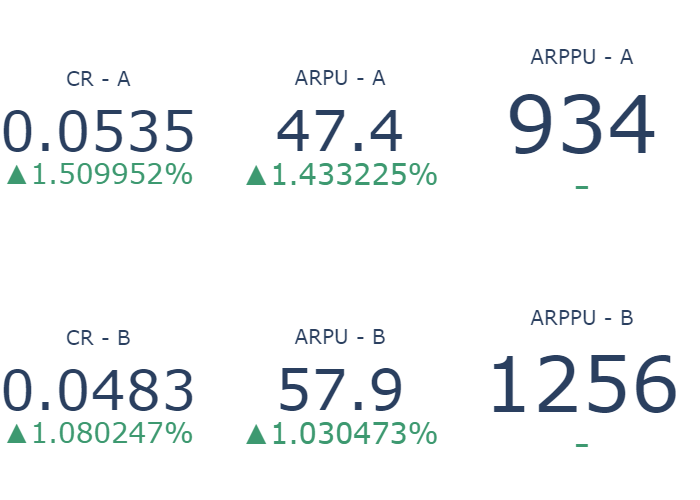

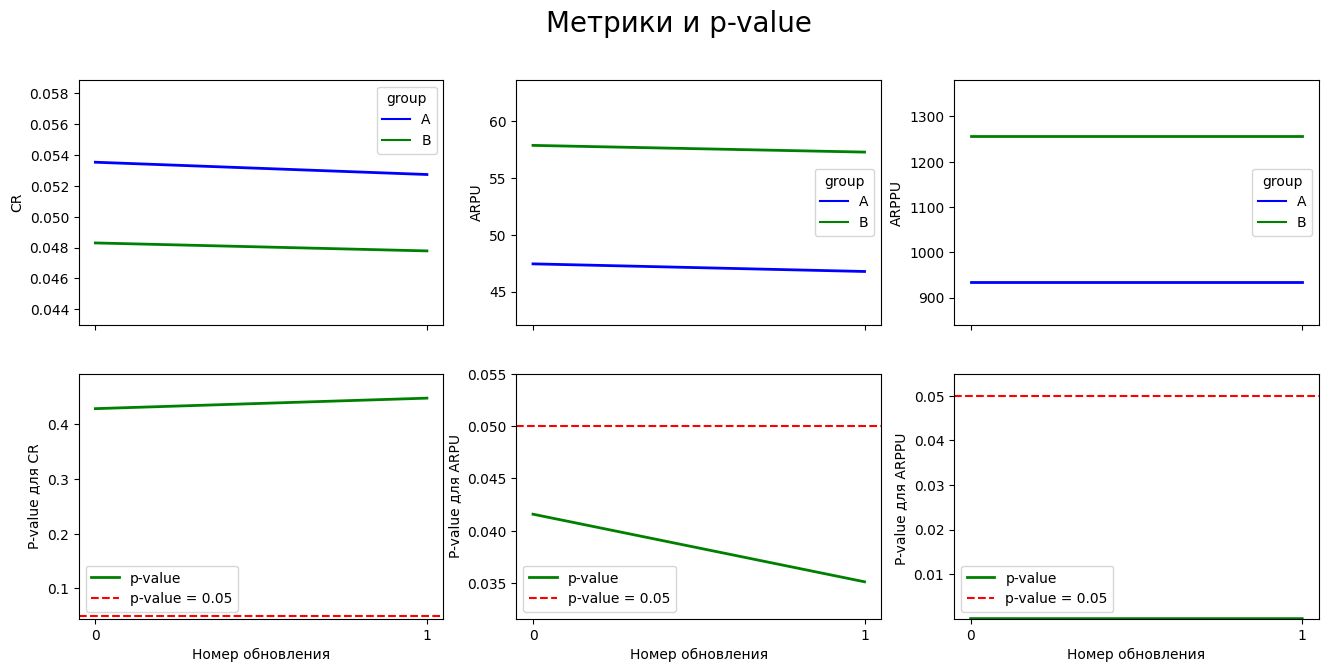

In [17]:
get_graphs(metrics)